In [87]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans, k_means
from sklearn.metrics import silhouette_score
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import seaborn as sns
%matplotlib inline

In [65]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [66]:
def base_features(df):
    return df[['SibSp', 'Parch']]
base_features_tf = FunctionTransformer(base_features, validate = False)

def dummies(df):
    cols = ['Pclass', 'Sex', 'Embarked']
    return pd.get_dummies(df[cols], columns = cols)
dummies_tf = FunctionTransformer(dummies, validate = False)

def fare(df):
    return df['Fare'].fillna(df['Fare'].median()).to_frame()
fare_tf = FunctionTransformer(fare, validate = False)

def age(df):
    return df['Age'].fillna(df['Age'].median()).to_frame()
age_tf = FunctionTransformer(age, validate = False)

# Create a Pipeline

In [67]:
fu = FeatureUnion([
    ('base_features_tf', base_features_tf),
    ('dummies_tf', dummies_tf),
    ('fare_tf', fare_tf)
])

model = GradientBoostingClassifier()

pipe = Pipeline([
    ('fu', fu),
    ('poly', PolynomialFeatures())
])

In [68]:
X = pipe.fit_transform(df)
y = df['Survived']

In [69]:
kf = StratifiedKFold(random_state=2003)

In [70]:
for train, test in kf.split(X,y):
    
    X_train = X[train, :]
    X_test = X[test, :]
    y_train = y[train]
    y_test = y[test]

In [73]:
cols = ['RF', 'TREE', 'LR']
shape = (df.shape[0], len(cols))
zeros = np.zeros(shape)
stacked_train = pd.DataFrame(zeros, index = df.index, columns = cols)
stacked_train.head()

,RF,TREE,LR
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [74]:
for train_indices, test_indices in kf.split(X,y):
    
    X_train = X[train_indices, :]
    X_test = X[test_indices, :]
    y_train = y[train_indices]
    y_test = y[test_indices]

In [82]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(random_state=2003)
for train_indices, test_indices in kf.split(X,y):
    X_train = X[train_indices, :]
    X_test = X[test_indices, :]
    y_train = y[train_indices]
    y_test = y[test_indices]
    
    model = LogisticRegression()
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    stacked_train.loc[test_indices, 'LR'] = pred
    
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    stacked_train.loc[test_indices, 'RF'] = pred
    
    model = DecisionTreeClassifier(max_depth = 1)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    stacked_train.loc[test_indices, 'TREE'] = pred
    
    
stacked_train.head()

,RF,TREE,LR
0,0.0,0.0,0.0
1,1.0,1.0,1.0
2,0.0,1.0,0.0
3,1.0,1.0,1.0
4,0.0,0.0,0.0


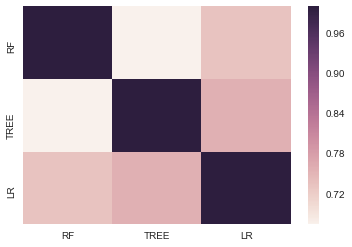

In [88]:
sns.heatmap(stacked_train.corr())

# FIT Stacked Model

In [90]:
stacked_model = AdaBoostClassifier()
params = {}
gs = GridSearchCV(stacked_model, param_grid=params)
gs.fit(stacked_train, y)
gs.best_score_

0.78900112233445563

# Prepare test Data

In [98]:
test_df = pd.read_csv('test.csv')

In [99]:
test = pipe.transform(test_df)

In [100]:
test

array([[   1.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,   61.29637264],
       [   1.        ,    1.        ,    0.        , ...,    1.        ,
           7.        ,   49.        ],
       [   1.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,   93.84765625],
       ..., 
       [   1.        ,    0.        ,    0.        , ...,    1.        ,
           7.25      ,   52.5625    ],
       [   1.        ,    0.        ,    0.        , ...,    1.        ,
           8.05      ,   64.8025    ],
       [   1.        ,    1.        ,    1.        , ...,    0.        ,
           0.        ,  499.89357889]])

# Create Test Stacked Models

In [95]:
lr = LogisticRegression()
dt = DecisionTreeClassifier(max_depth = 1)
rf = RandomForestClassifier()

lr.fit(X,y)
dt.fit(X,y)
_= rf.fit(X,y)

# Create Stacked DataFrame for Test

In [101]:
shape = (test_df.shape[0], len(cols))
zeros = np.zeros(shape)
stacked_test = pd.DataFrame(zeros, index = test_df.index, columns = cols)
stacked_test.head()

,RF,TREE,LR
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [102]:
stacked_test['LR'] = lr.predict(test)
stacked_test['TREE'] = dt.predict(test)
stacked_test['RF'] = rf.predict(test)
stacked_test.head()

,RF,TREE,LR
0,0,0,0
1,1,1,0
2,0,0,0
3,0,0,0
4,1,1,0


# Generate Final Prediction

In [107]:
pred = gs.predict(stacked_test)
test_df['Survived'] = pred

In [108]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived Bola,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1,1


In [109]:
test_df[['PassengerId', 'Survived']].to_csv('submission7.csv', index = False)